In [2]:
import numpy as np
import scipy as sp
from scipy import integrate, interpolate
import scipy.fft as fft
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import h5py
import os
import time

In [3]:
# Global Rocket Parameters
xi = 50
Gmu = 1e-12
GammaFrac = 0.1
vf = 0.3
nRockets = 10

# Global Simulation Parameters
tmax = 100
L = 100
binS = 100
zi = 127
dx = L / binS
h = 0.7
rhoScale = 4.78e-20 # Mpc / Msun

# Global Physical Parameters
t0 = 4213 / h # Mpc / h
H0 = 0.0003333

In [4]:
# Cluster dirs
# homeDir = "/cluster/tufts/hertzberglab/nshah14/"
# sharedDir = "/cluster/tufts/hertzberglab/shared/Rockets/"
# simName = "Sim_100v"
# simDir = sharedDir + simName + "/"

# Local dirs
homeDir = "C:\\Users\\NeilShah\\Documents\\PhD\\Rocket Capture\\"
simName = "Sim_100v"
simDir = homeDir + simName + "\\"

In [5]:
def getHubbleEvol():
    OMatter = 0.25
    OLambda = 0.75

    da_dt = lambda a, t: a * H0 * np.sqrt(OMatter / a**3 + OLambda)

    a0 = 1 / (1 + zi)
    tInt = np.linspace(0, 1.1 / H0, 1000)
    af = interpolate.InterpolatedUnivariateSpline(tInt, integrate.odeint(da_dt, y0=a0, t=tInt)[:, 0])
    aDotf = af.derivative(n=1)
    tEnd = sp.optimize.fsolve(lambda t: af(t) - 1.0, x0=(1.0 / H0))[0]

    tArr = np.asarray([(tEnd + t)**(t / tmax) - 1 for t in range(tmax)])
    aArr = np.asarray([af(t) for t in tArr])
    HArr = np.asarray([aDotf(t) / af(t) for t in tArr])

    return tArr, aArr, HArr

In [6]:
def getMass():
    tFix = 50
    massTab = np.zeros(3)

    snapDir = simDir + "snapdir_{:03d}/".format(tFix)
    path1 = snapDir + "snapshot_{:03d}.0.hdf5".format(tFix)
    fil = h5py.File(path1, 'r')

    ptypeN = 3
    for pi in np.arange(0, ptypeN):
        ptype = pi + 1
        datGet = "/PartType{:d}/Masses".format(ptype)
        massTab[pi] = np.asarray(fil[datGet])[0]

    return massTab

In [7]:
def toMS(t):
    s = np.floor(np.mod(t, 60))
    m = np.floor(np.mod(t, 3600) / 60)
    h = np.floor(t / 3600)

    if t < 1:
        tstr = "{:f} s".format(t)
    elif t < 3600:
        tstr = "{:02d}m {:02d}s".format(int(m), int(s))
    else:
        tstr = "{}h {:02d}m {:02d}s".format(int(h), int(m), int(s))
    return tstr

In [8]:
def getHaloC(t):
    haloFinalDir = simDir + "snapdir_{:03d}\\".format(t)
    pathArr = np.asarray(os.listdir(haloFinalDir))
    haloFinalCoords = np.empty((0, 3))

    for pathi in np.arange(0, pathArr.size):
        datGet = "/PartType1/Coordinates"
        try:
            coords = np.asarray(h5py.File(haloFinalDir + pathArr[pathi], 'r')[datGet])
        except KeyError:
            continue
        haloFinalCoords = np.concatenate([haloFinalCoords, coords], axis=0)

    haloC = np.asarray([np.mean(haloFinalCoords[:, i]) for i in range(3)])
    return(haloC)

def getRVir(t):
    groupDir = simDir + "groups_{:03d}/".format(t)
    file = h5py.File(groupDir + "fof_subhalo_tab_{:03d}.0.hdf5".format(t), 'r')

    try:
        RVir200 = np.asarray(file["/Group/Group_R_Crit200"])[0]
        RVir500 = np.asarray(file["/Group/Group_R_Crit500"])[0]
    except KeyError:
        RVir200 = -1
        RVir500 = -1
    return RVir200, RVir500

In [9]:
def getCoords(t, ptype=1):
    snapDir = simDir + "snapdir_{:03d}\\".format(t)
    pathArr = np.asarray(os.listdir(snapDir))
    
    ptypeN = 3
    coordsArr = np.empty((0, 3), dtype=float)

    pi = ptype - 1
    
    for pathi in np.arange(0, pathArr.size):
        datGet = "/PartType{:d}/Coordinates".format(ptype)
        try:
            coords = np.asarray(h5py.File(snapDir + pathArr[pathi], 'r')[datGet])
            coordsArr = np.concatenate([coordsArr, coords], axis=0)
        except KeyError:
            # print("   (Warning! Could not find ptype {:d} for snapshot t = {:d})".format(ptype, t))
            pass
    
    return(coordsArr)

def getHaloCoords(t):
    groupDir = simDir + "groups_{:03d}\\".format(t)
    snapDir = simDir + "snapdir_{:03d}\\".format(t)
    groupPaths = np.asarray(os.listdir(groupDir))
    snapPaths = np.asarray(os.listdir(snapDir))

    ptype = 1
    coordsArr = np.empty((0, 3), dtype=float)

    for i, pathi in enumerate(snapPaths):
        datGet = "/PartType{:d}/Coordinates".format(ptype)
        try:
            coords = np.asarray(h5py.File(snapDir + pathi, 'r')[datGet])
            coordsArr = np.concatenate([coordsArr, coords], axis=0)
        except KeyError:
            # print("   (Warning! Could not find ptype {:d} for snapshot t = {:d})".format(ptype, t))
            pass
    
    haloCoords = -1
    for i, pathi in enumerate(groupPaths):
        gfile = h5py.File(groupDir + pathi, 'r')
        try:
            haloInit = int(np.asarray(gfile["/Group/GroupOffsetType/"])[0, 0])
            haloN = int(np.asarray(gfile["/Group/GroupLen/"])[0])
            haloCoords = coordsArr[haloInit:(haloInit + haloN + 1), :]
            break
        except KeyError:
            pass
    
    return(haloCoords)

In [ ]:
fig = plt.figure(1, figsize=(8, 8), dpi=100)
ax = plt.gca()
saveDir = simDir + "HaloEvolPlots/"
if not os.path.exists(saveDir):
    os.makedirs(saveDir)

for t in range(tmax):
    haloC = getHaloC(t)
    coords = getCoords(t)
    xmin, xmax, ymin, ymax = [np.min(coords[:, 0]), np.max(coords[:, 0]), np.min(coords[:, 1]), np.max(coords[:, 1])]
    pltLims = 1.2 * (np.asarray([xmin, xmax, ymin, ymax]) - np.asarray([haloC[0], haloC[0], haloC[1], haloC[1]])) + np.asarray([haloC[0], haloC[0], haloC[1], haloC[1]])
    RVir200, RVir500 = getRVir(t)

    plt.scatter(coords[:, 0], coords[:, 1], c="k", s=5)
    if RVir200 != -1:
        ax.add_patch(plt.Circle((haloC[0], haloC[1]), RVir200, fill=False, color="blue", zorder=10))
        ax.add_patch(plt.Circle((haloC[0], haloC[1]), RVir500, fill=False, color="red", zorder=10))

    plt.title("Halo Evolution with Dynamic Axes Limits (t = {:03d})".format(t))
    plt.xlim((pltLims[0], pltLims[1]))
    plt.ylim((pltLims[2], pltLims[3]))
    plt.savefig(saveDir + "HaloEvol__t_{:03d}".format(t))
    plt.clf()


In [23]:
test = 3
2 < test < 5

True

(866995, 3)
The number of particles inside RCrit200 is: 691669 / 866995 (79.777738%)
The number of particles inside RCrit500 is: 569703 / 866995 (65.710068%)


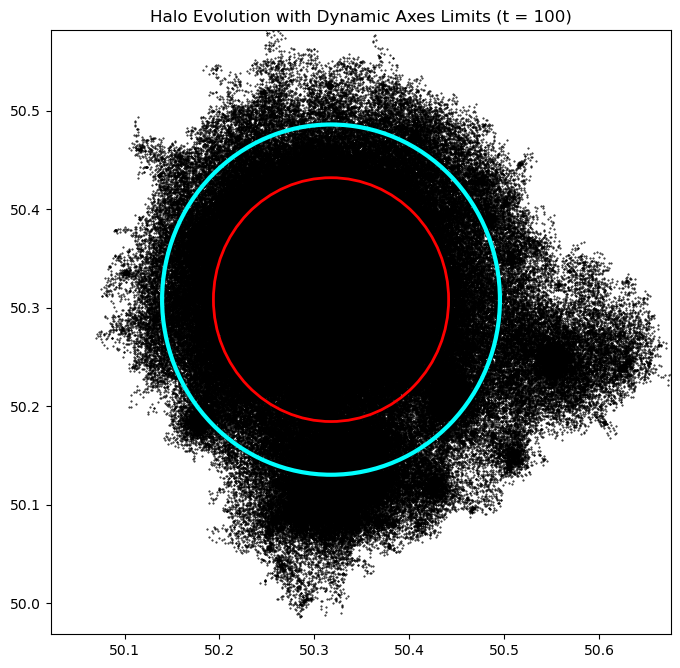

In [41]:
fig = plt.figure(1, figsize=(8, 8), dpi=100)
ax = plt.gca()
ax.clear()

t = 100
RVir200, RVir500 = getRVir(t)
coords = getHaloCoords(t)
haloC = np.asarray([np.mean(coords[:, i]) for i in range(3)])
print(coords.shape)

num200 = 0
num500 = 0
for ci, coord in enumerate(coords):
    dr = np.linalg.norm(coord - haloC)
    if -RVir200 < dr < RVir200:
        num200 += 1
    if -RVir500 < dr < RVir500:
        num500 += 1
print("The number of particles inside RCrit200 is: {:d} / {:d} ({:f}%)".format(num200, coords.shape[0], 100*(num200 / coords.shape[0])))
print("The number of particles inside RCrit500 is: {:d} / {:d} ({:f}%)".format(num500, coords.shape[0], 100*(num500 / coords.shape[0])))

nx, binsx = np.histogram(coords[:, 0], bins=20)
ny, binsy = np.histogram(coords[:, 1], bins=20)
xmin, xmax = [np.min(np.asarray([binsx[i] for i in np.arange(0, binsx.size - 1) if nx[i] > 10])), np.max(np.asarray([binsx[i] for i in np.arange(1, binsx.size) if nx[i - 1] > 10]))]
ymin, ymax = [np.min(np.asarray([binsy[i] for i in np.arange(0, binsy.size - 1) if ny[i] > 10])), np.max(np.asarray([binsy[i] for i in np.arange(1, binsy.size) if ny[i - 1] > 10]))]
pltLims = 1.0 * (np.asarray([xmin, xmax, ymin, ymax]) - np.asarray([haloC[0], haloC[0], haloC[1], haloC[1]])) + np.asarray([haloC[0], haloC[0], haloC[1], haloC[1]])
RVir200, RVir500 = getRVir(t)

plt.scatter(coords[:, 0], coords[:, 1], c="k", s=0.2)
if RVir200 != -1:
    ax.add_patch(plt.Circle((haloC[0], haloC[1]), RVir200, fill=False, color="cyan", linewidth=3, zorder=10))
    ax.add_patch(plt.Circle((haloC[0], haloC[1]), RVir500, fill=False, color="red", linewidth=2, zorder=10))

plt.title("Halo Evolution with Dynamic Axes Limits (t = {:03d})".format(t))
plt.xlim((pltLims[0], pltLims[1]))
plt.ylim((pltLims[2], pltLims[3]))
plt.show()

In [38]:
n, bins = np.histogram(coords[:, 0] - haloC[0], bins=20)
print(n)
print(bins)
print([bins[i] for i in range(bins.size - 1) if n[i] > 10])

[     1      0      0      0      0      0      0      0      0      0
      0    176  11425  75997 371911 292892  76360  22365  13320   2548]
[-1.09286223 -1.02033759 -0.94781295 -0.8752883  -0.80276366 -0.73023902
 -0.65771437 -0.58518973 -0.51266509 -0.44014045 -0.3676158  -0.29509116
 -0.22256652 -0.15004187 -0.07751723 -0.00499259  0.06753205  0.1400567
  0.21258134  0.28510598  0.35763063]
[-0.2950911597342496, -0.22256651678991368, -0.15004187384557777, -0.07751723090124174, -0.004992587956905936, 0.06753205498743009, 0.14005669793176612, 0.21258134087610192, 0.28510598382043795]


In [71]:
t = 50
groupDir = simDir + "groups_{:03d}\\".format(t)
pathArr = np.asarray(os.listdir(groupDir))

for i, pathi in enumerate(pathArr):
    print("Evaluating: {}".format(pathi))
    file = h5py.File(groupDir + pathi, 'r')
    print(file.keys())
    try:
        # print(file["/Group"].keys())
        # print(np.asarray(file["/Group/Group_R_Crit200"]).shape)
        # print("\n")

        gfil = file["/Group"]
        gkeys = gfil.keys()
        print(gkeys)
        for key in gkeys:
            print(key)
            print(np.asarray(gfil[key]))
    except KeyError:
        print("Couldn't find group!\n\n")
    

# print("Processing: {}\n".format(groupDir))
# for i, pathi in enumerate(pathArr):
#     print("Evaluating: {}".format(pathi))
#     file = h5py.File(groupDir + pathi, 'r')
#     print(file.keys())
#     try:
#         print(file["/Header"])
#         print(file["/Header"].attrs.keys())
#         print(file["/Header"].attrs["Nids_ThisFile"])
#         print("\n")
#     except KeyError:
#         print("Couldn't find Header!\n\n")

Evaluating: bak-fof_subhalo_tab_090.0.hdf5
<KeysViewHDF5 ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']>
<KeysViewHDF5 ['GroupAscale', 'GroupFirstSub', 'GroupLen', 'GroupLenType', 'GroupMass', 'GroupMassType', 'GroupNsubs', 'GroupOffsetType', 'GroupPos', 'GroupVel', 'Group_M_Crit200', 'Group_M_Crit500', 'Group_M_Mean200', 'Group_M_TopHat200', 'Group_R_Crit200', 'Group_R_Crit500', 'Group_R_Mean200', 'Group_R_TopHat200']>
GroupAscale
[0.5077744]
GroupFirstSub
[0]
GroupLen
[552265]
GroupLenType
[[     0 552265      0      0      0      0]]
GroupMass
[103.626236]
GroupMassType
[[  0.       103.626236   0.         0.         0.         0.      ]]
GroupNsubs
[156]
GroupOffsetType
[[0 0 0 0 0 0]]
GroupPos
[[47.708534 47.113613 48.158257]]
GroupVel
[[156.29317 202.55457 152.60051]]
Group_M_Crit200
[103.86064]
Group_M_Crit500
[83.21449]
Group_M_Mean200
[111.67999]
Group_M_TopHat200
[110.383995]
Group_R_Crit200
[0.23411442]
Group_R_Crit500
[0.16020735]
Group_R_Mean200
[0.267851]
G

In [102]:
t = 100
groupDir = simDir + "groups_{:03d}\\".format(t)
groupPaths = np.asarray(os.listdir(groupDir))

for i, pathi in enumerate(groupPaths):
    print(pathi)
    try:
        gfile = h5py.File(groupDir + pathi, 'r')
        haloN = np.asarray(gfile["/Group/GroupLen/"])
        
        print(haloN)
    except KeyError:
        print("Couldn't find Groups!")
    print("")
    

fof_subhalo_tab_100.0.hdf5
[866994]

fof_subhalo_tab_100.1.hdf5
Couldn't find Groups!

fof_subhalo_tab_100.2.hdf5
Couldn't find Groups!

fof_subhalo_tab_100.3.hdf5
[261469]

fof_subhalo_tab_100.4.hdf5
[49964 34075 22436 21095 18397 14729 12650  9068  8582  8189  7949  7285
  6627  5961  5438  5256  5061  4863  4588  4077  3973  3944  3753  3728
  3352  3273  3221  3199  2941  2792  2755  2570  2505  2251  2233  2184
  2169  2011  1945  1853  1743  1728  1653  1642  1619  1567  1497  1478
  1467  1464  1429  1424  1423  1375  1368  1361  1352  1337  1335  1324
  1320  1306  1276  1235  1218  1177  1170  1155  1151  1135  1119  1083
  1082  1048  1042  1032  1027   969   964   931   917   904   891   881
   869   864   859   851   838   837   836   831   824   811   810   796
   793   783   772   766   764   762   756   744   743   743   717   698
   692   688   680   670   669   664   661   659   657   650   650   642
   632   624   624   615   607   595   588   586   577   576   575   

In [79]:
print(np.asarray(file["/Group/GroupLen"]))
offsets = np.asarray(file["/Group/GroupOffsetType/"])
print(offsets)

[552265]
[[0 0 0 0 0 0]]


0.17783348
[0.027435131, 0.01784205]


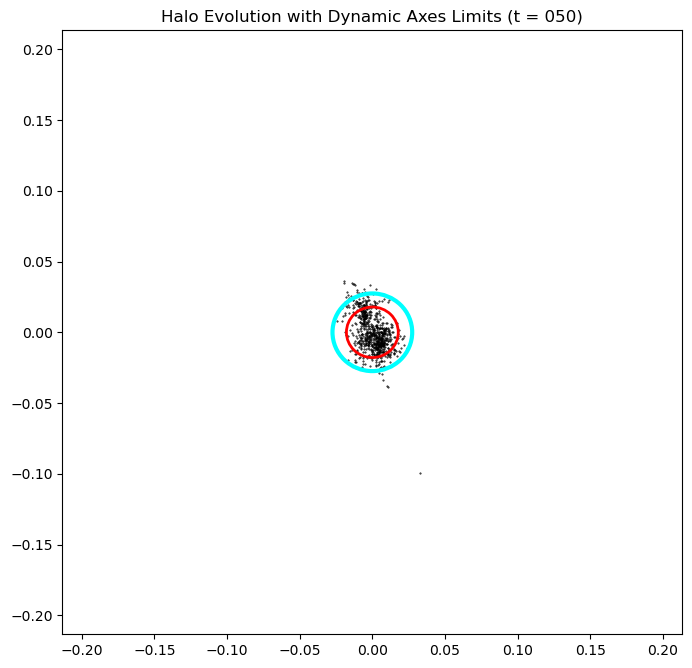

In [56]:
def getHaloPlt(t, axesLims="Fixed"):
    saveDir = simDir + "HaloEvolPlots_{}Lims\\".format(axesLims)
    # savePath = saveDir + "HaloEvol__t_{:03d}.png".format(t)
    if not os.path.exists(saveDir):
        os.makedirs(saveDir)
    
    fig = plt.figure(1, figsize=(8, 8), dpi=100)
    ax = plt.gca()

    RVir200, RVir500 = getRVir(t)
    print([RVir200, RVir500])
    coords = getHaloCoords(t)
    haloC = np.asarray([np.mean(coords[:, i]) for i in range(3)])

    # nx, binsx = np.histogram(coords[:, 0], bins=20)
    # ny, binsy = np.histogram(coords[:, 1], bins=20)
    # try:
    #     xmin, xmax = [np.min(np.asarray([binsx[i] for i in np.arange(0, binsx.size - 1) if nx[i] > 10])), np.max(np.asarray([binsx[i] for i in np.arange(1, binsx.size) if nx[i - 1] > 10]))]
    #     ymin, ymax = [np.min(np.asarray([binsy[i] for i in np.arange(0, binsy.size - 1) if ny[i] > 10])), np.max(np.asarray([binsy[i] for i in np.arange(1, binsy.size) if ny[i - 1] > 10]))]
    # except ValueError:
    #     xmin, xmax = [np.min(coords[:, 0]), np.max(coords[:, 0])]
    #     ymin, ymax = [np.min(coords[:, 1]), np.max(coords[:, 1])]
    # pltLims = 1.0 * (np.asarray([xmin, xmax, ymin, ymax]) - np.asarray([haloC[0], haloC[0], haloC[1], haloC[1]])) + np.asarray([haloC[0], haloC[0], haloC[1], haloC[1]])
    if axesLims == "Dynamic":
        pltLims = 1.2 * np.asarray([-RVir200, RVir200, -RVir200, RVir200]) + np.asarray([haloC[0], haloC[0], haloC[1], haloC[1]])
    if axesLims == "Fixed":
        RVirFinal, _ = getRVir(tmax)
        pltLims = 1.2 * np.asarray([-RVirFinal, RVirFinal, -RVirFinal, RVirFinal])

    plt.scatter(coords[:, 0] - haloC[0], coords[:, 1] - haloC[1], c="k", s=0.2)
    if RVir200 != -1:
        ax.add_patch(plt.Circle((0, 0), RVir200, fill=False, color="cyan", linewidth=3, zorder=10))
        ax.add_patch(plt.Circle((0, 0), RVir500, fill=False, color="red", linewidth=2, zorder=10))

    plt.title("Halo Evolution with Dynamic Axes Limits (t = {:03d})".format(t))
    plt.xlim((pltLims[0], pltLims[1]))
    plt.ylim((pltLims[2], pltLims[3]))

    # plt.savefig(savePath)
    plt.show()

RVirFinal, _ = getRVir(tmax)
print(RVirFinal)
getHaloPlt(50)

In [22]:
t = 100
groupDir = simDir + "groups_{:03d}\\".format(t)
groupPaths = groupPaths = np.asarray(os.listdir(groupDir))
gfile = h5py.File(groupDir + groupPaths[0], 'r')
groups = gfile["/Group/"]
gkeys = groups.keys()

print(gkeys, end="\n\n")
for key in gkeys:
    keyEv = np.asarray(groups[key])
    print("{:20} : {}".format(key, keyEv))

<KeysViewHDF5 ['GroupAscale', 'GroupFirstSub', 'GroupLen', 'GroupLenType', 'GroupMass', 'GroupMassType', 'GroupNsubs', 'GroupOffsetType', 'GroupPos', 'GroupVel', 'Group_M_Crit200', 'Group_M_Crit500', 'Group_M_Mean200', 'Group_M_TopHat200', 'Group_R_Crit200', 'Group_R_Crit500', 'Group_R_Mean200', 'Group_R_TopHat200']>

GroupAscale          : [1.]
GroupFirstSub        : [0]
GroupLen             : [866994]
GroupLenType         : [[     0 866994      0      0      0      0]]
GroupMass            : [162.7023]
GroupMassType        : [[  0.     162.7023   0.       0.       0.       0.    ]]
GroupNsubs           : [234]
GroupOffsetType      : [[0 0 0 0 0 0]]
GroupPos             : [[50.30435  50.334766 50.52013 ]]
GroupVel             : [[336.91208 414.02316 299.50467]]
Group_M_Crit200      : [130.7333]
Group_M_Crit500      : [110.27366]
Group_M_Mean200      : [168.76224]
Group_M_TopHat200    : [148.09958]
Group_R_Crit200      : [0.17783348]
Group_R_Crit500      : [0.12380219]
Group_R_Mean200 